In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline 

In [2]:
# import all pyphysio classes and methods
import pyphysio as ph

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [3]:
# import data and creating a signal
df_BVP = pd.read_csv('BVP_pp63.csv', header=None)


In [4]:
#count rows 
n_of_rows = df_BVP.count()
print(n_of_rows)

0    231671
dtype: int64


In [5]:
#count n of rows to get time of recording (s) 
n_of_rows = df_BVP.count()
print(n_of_rows)
#walk time in seconds 
walk_time_seconds = n_of_rows/64
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)


0    231671
dtype: int64
0    3619.859375
dtype: float64
0    60.33099
dtype: float64


In [6]:
#create BVP signal 
fsamp = 64  #64 Hz 
t_start = 0

ecg = ph.EvenlySignal(values = df_BVP, sampling_freq = fsamp, signal_type = 'ecg')

In [7]:
print(ecg.get_start_time())

0


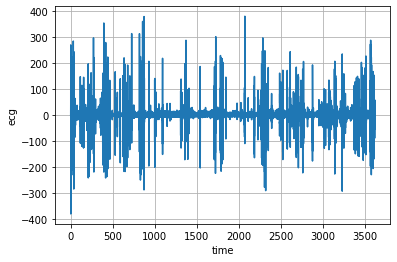

In [8]:
ecg.plot()

In [9]:
ibi = ph.BeatFromECG()(ecg)

In [10]:
ibi.get_duration() #seconds 

3619.859375

In [11]:
# create label
label = np.zeros(3619)
label[0:600] =1
label[600:3619] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label') 
#sampling_freq here is not intended as real sampfeq, only the distance between one point and the other (e.g. 10 = 10 units between 'begin' & 'end')

In [12]:
# (optional) IIR filtering : remove high frequency noise
#ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

In [13]:
# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

In [14]:
# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096

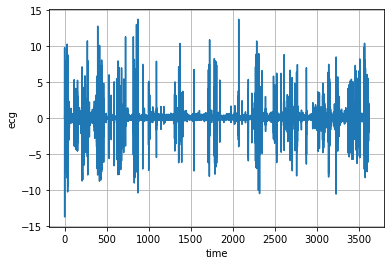

In [15]:
ecg.plot()

In [16]:
ibi = ph.BeatFromECG()(ecg)

In [17]:
ibi.get_duration()


3619.859375

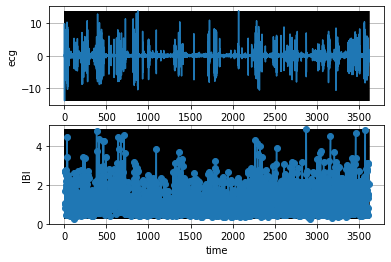

In [18]:
# check results so far
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

In [19]:
### physiological indicators 

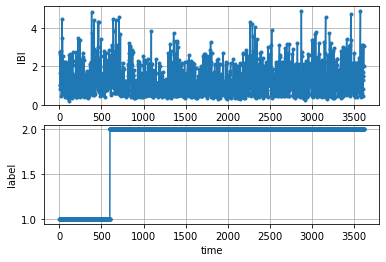

In [20]:
# check label
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()

In [21]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [22]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [23]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]].ravel()
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]].ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c172d0e90>,
 'caps': [<matplotlib.lines.Line2D at 0x1c172d0b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c172e5d90>,
 'medians': [<matplotlib.lines.Line2D at 0x1c172cbb50>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c172cb490>,
 'means': []}

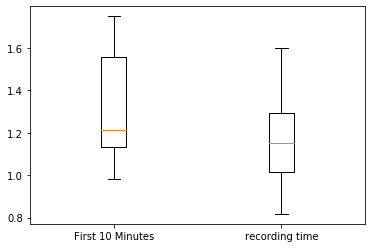

In [24]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['First 10 Minutes', 'recording time'])

In [25]:
HRV_FD = ph.preset_hrv_fd() #frequency domain HRV indicators
print(HRV_FD)

print(HRV_FD[0].get())

[IBI_VLF_Pow, IBI_LF_Pow, IBI_HF_Pow, IBI_Total_Pow]
{'freq_min': 1e-05, 'freq_max': 0.04, 'method': 'ar', 'interp_freq': 4, 'name': 'IBI_VLF_Pow'}


In [26]:
FD_HRV_ind, col_names = ph.fmap(fixed_length, ph.preset_hrv_fd(), ibi.resample(4))

In [27]:
import pandas as pd

# create a pandas dataframe
FD_HRV_pp63_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_pp63_df

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,1.226807,61.226807,1.0,215.608047,788.231298,847.463913,2500.226637
1,61.226807,121.226807,1.0,383.657494,837.099406,899.263623,2771.846991
2,121.226807,181.226807,1.0,426.019454,591.817904,675.420791,2384.646952
3,181.226807,241.226807,1.0,548.858631,1120.254359,1051.770250,3316.587600
4,241.226807,301.226807,1.0,257.715495,597.588358,828.775400,2429.487470
5,301.226807,361.226807,1.0,122.107028,367.485247,674.026068,1964.415696
6,361.226807,421.226807,1.0,523.330306,1376.679134,1148.745667,3693.639917
7,421.226807,481.226807,1.0,515.859121,1168.000507,1296.309874,3621.405302
8,481.226807,541.226807,1.0,370.766275,923.244415,1023.419673,3079.080178
9,601.226807,661.226807,2.0,774.096524,1490.112774,864.578118,3774.855085


In [28]:
#save data 
FD_HRV_pp63_df.to_csv('FD_HRV_pp63.csv')